# Softmax policy for rwnet
(We retrain rwnet here due to a staggered workflow where we could not keep data between sessions).

For every test we follow the same structure:
1. Train 3 agents using the same architecture.
2. Plot the training performance combining the performance of all 3 agents.
3. Consider the performance of all 3 agents in the 50 predefined test worlds.
4. Determine the best performing agent by averaging across 50 predefined test worlds.
5. Compare with the other relevant architectures.
6. Decide on which setup to continue with, focusing on the best performers in most cases (but also taking the variance of the architecture into account).

In [10]:
from main import *
from training_evaluation import *

#We define our training function
train = lambda obj, max_episodes = 150, policy = None : sarsa(obj, world_generator=dense_world, policy= policy, decay_factor=0.95, threshold=max_episodes-100, max_episodes=max_episodes, episode_duration=300)

#We have to define two policies due to a quirk of our code. With more time this should be restructured, it is not well-written.
#Whats worse is that the policies are very slow to evaluate...
softmax_policy_training = lambda feats, network, eps : eps_greedy(eps, softmax_choice(network(*feats)))
softmax_policy_test = lambda feats, network, eps : eps_greedy(eps, softmax_choice(network(*feats)), mark_eps = True)

#This is a tad goofy, but we use the same structure as above
train_softmax = lambda obj, max_episodes = 150, policy = softmax_policy_training : sarsa(obj, world_generator=dense_world, policy= policy, decay_factor=0.95, threshold=max_episodes-100, max_episodes=max_episodes, episode_duration=300)

In [2]:
#We have a number of worlds set aside for comparison
test_worlds = [dense_world() for i in range(50)]

#On each world we shall run an episode - this is our test function applied to the world and network. 
#We must allow custom policies (e.g. softmax).
test_single_world = lambda world, inet, policy: run_episode(world, inet, epsilon = 0, episode_duration = 300, policy=policy)

#To aggregate results we run our tests not on one world but many. 
#This allows us to compare agents after training in an exhaustive manner.
test = lambda inet, policy = None: [sum(test_single_world(world, inet, policy).rewards) for world in test_worlds]
test_softmax = lambda inet, policy = softmax_policy_test: [sum(test_single_world(world, inet, policy).rewards) for world in test_worlds]

### rwnet (again)

In [4]:
rewards_df_rwnet, test_rewards_df_rwnet = run_training(rw.rwnet_gen, train, test)

In [5]:
rolled_df_rwnet = roll_training_data(rewards_df_rwnet)

In [29]:
#We print the performance:
perf, mean_rwnet, err_rwnet = metrics(test_rewards_df_rwnet)

             Mean       Err.
Session 0  443.22  19.662713
Session 1  411.68  43.635152
Session 2  406.22  29.378436


### rwnet with softmax policy

In [10]:
rewards_df_rwnet_sm, test_rewards_df_rwnet_sm = run_training(rw.rwnet_gen, train_softmax, test_softmax)

In [11]:
rolled_df_rwnet_sm = roll_training_data(rewards_df_rwnet_sm)

In [28]:
#We print the performance:
perf_sm, mean_rwnet_sm, err_rwnet_sm = metrics(test_rewards_df_rwnet_sm)

             Mean       Err.
Session 0  403.40  30.163013
Session 1  451.20  28.536851
Session 2  460.76  22.374814


## Comparison

### Performance

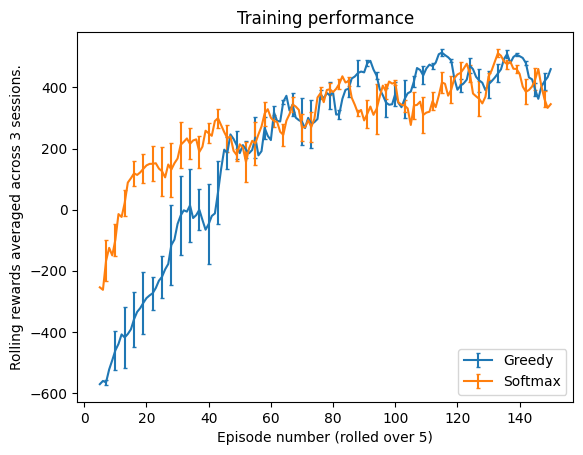

In [14]:
rolled_dfs = [ rolled_df_rwnet, rolled_df_rwnet_sm]
names= [ 'Greedy', 'Softmax']
fp = multiplot_training(rolled_dfs, names, 150, sessions = 3, roll_nr = 5)
plt.savefig('softmax.png')
plt.show()

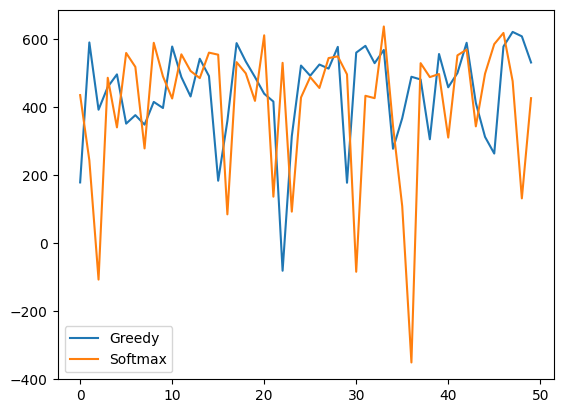

In [31]:
rw_best = test_rewards_df_rwnet[perf]
rw_sm_best= test_rewards_df_rwnet[perf_sm]
plt.plot(rw_best, label = "Greedy")
plt.plot(rw_sm_best, label = "Softmax")
plt.legend()

In [34]:
print(f"Best episode performance for greedy policy: {max(rw_best)}")
print(f"Worst episode performance for greedy policy: {min(rw_best)}")
print(f"Best episode performance for softmax policy: {max(rw_sm_best)}")
print(f"Worst episode performance for softmax policy: {min(rw_sm_best)}")

Best episode performance for greedy policy: 621
Worst episode performance for greedy policy: -82
Best episode performance for softmax policy: 637
Worst episode performance for softmax policy: -352


### Qualitative analysis: Running episodes for an agent trained using softmax
The interested reader can re-run the code below to get a running visualization of what the softmax policy agent does in an episode. 

The specific performance will of course vary as we do not fix seeds. Generally the agent appears to perform well, about the same as a the regular agent. It manages to avoid getting stuck most of the time.

As can be seen from the rewards plot, the agent trained in my case did have some difficulties, and did spend some time backtracking around step ~ 50 and step ~ 150. This shows a typical flaw of these architectures - they cannot take global structures into account!

This will show:
- A title displaying the value $Q(S,:)$. These run by fast, so if you want to see them more closely, set 'pause = T' in the call 'plot_aug_episode' where T is the desired amount of time to watch each step, in seconds.
- The rewards plot for the episode
- The agents local map
- The internal visits state (i.e. the local map layer that tracks the number of visits to nearby positions)
- The agents full world map
- The features that are actually fed into the agent ('Seen', 'Terrain', 'Visits' which generally overlaps with the internal state) before pointwise convolution.
- The actual world map (which the agent does not have access to)
- The adjusted local map: The map after pointwise convolution which is fed into the ANN doing pathfinding. Note that this map is *learned* and so it will vary from session to session.

Note that this requires running the first two blocks of code from above, and also note that training for the softmax policy does take some time due to an innefficient implementation. Therefore I have saved a trained agent which can be run without training (the first two code blocks still need to be run!), but the world will still be randomly generated.

In [11]:
sm_rwnet = rw.rwnet_gen()
#train_softmax(sm_rwnet);
#sm_rwnet.save()

In [12]:
sm_rwnet.load()

In [19]:
#Only run this the first time.
#world = dense_world()
#world_map_no_pad = world.world_map[WORLD_BOUNDARY_PADDING:-WORLD_BOUNDARY_PADDING, WORLD_BOUNDARY_PADDING:-WORLD_BOUNDARY_PADDING]
#np.save('softmax illu', world_map_no_pad)
world = GridWorldEnvironment(np.load("global_illu.npy"), 9)

In [24]:
random.seed(3141592)
outcome = run_episode(world, sm_rwnet, policy = softmax_policy_test, epsilon = 0, episode_duration = 300)

In [25]:
print(f"Total reward: {sum(outcome[2])}")

Total reward: 448


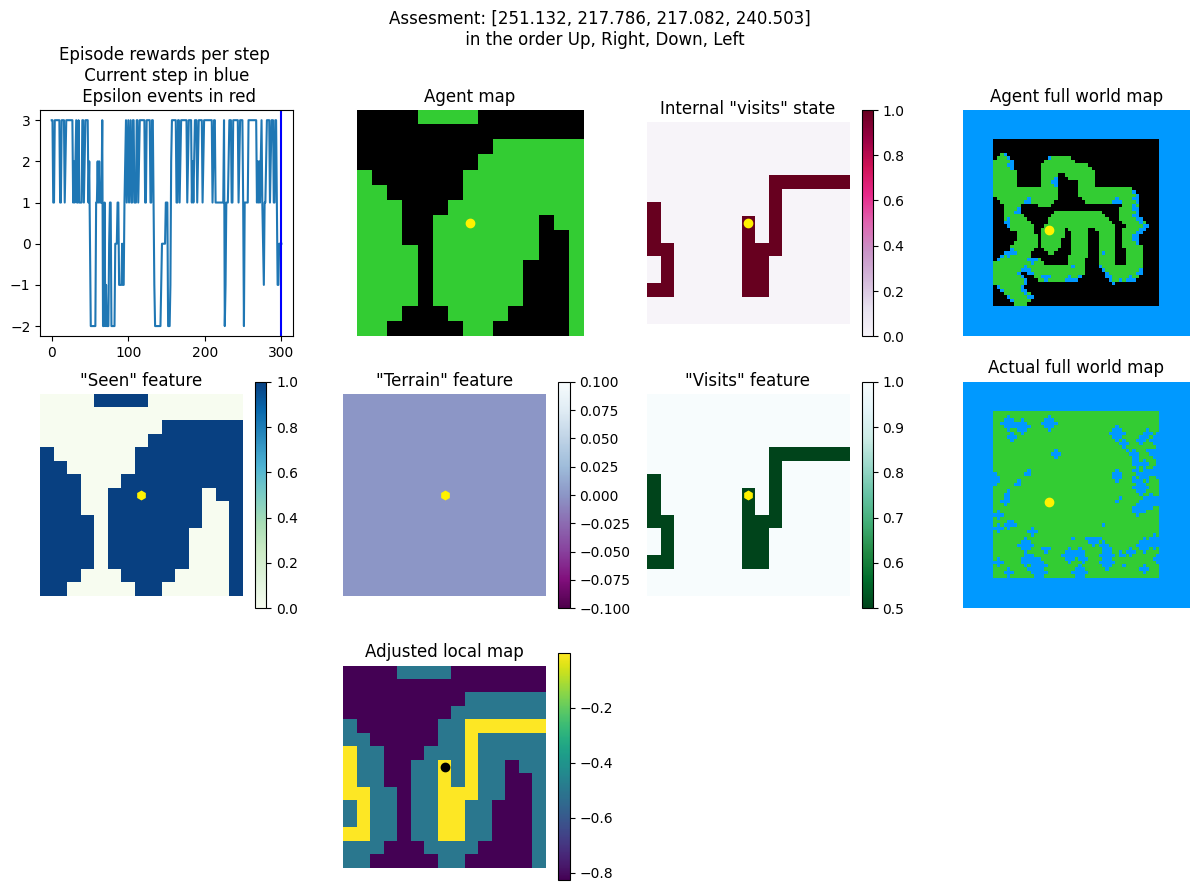

<Figure size 640x480 with 0 Axes>

In [26]:
plot_aug_episode(outcome, world.world_map)

This is a quite good performance, and we picked it because it displays some typical issues with getting stuck in coreners and regions with higher water density.